# Chest X-Ray Image Classification Project
Group members: Titilayo(Teetee)Amuwo, Paul Shin, and Tony Bennett



## Overview

This notebook contains our steps to solving a data science predictive modeling image classification problem.which involves the Chest X-rays Images from pediatric patients of one of five years old. Our aim is to develop an accurate model that predicts whether or not a patient have pneumonia based on the X-ray images. After trying different models we decided to use a pretrained CNN model VGG19 and decided to tune it with our dataset and test it on unseen dataset to see how it performed. We convert the learning problem into an optimization problem, define a loss function and then optimize the algorithm to minimize the loss function.

## Business Problem

Pneumonia is a respiratory infection diseases caused by bacteria or viruses especially in developing countries and underdeveloped nations,where high levels of pollution and unhygenic living conditions is mostly common. Early detection of pneumonia is crucial to ensure curative treatment and to increase survival rates. Chest X-Ray imaging is the most frequently used method for diagnosing pneumonia. However, the examination of the Chest X-rays is a challenging task and is prone to subjective variability based on human errors. The normal process involves grading the X-Rays with a scoring system.The scores are classified further into mild(score 1-4), moderate(score 5 -8) and severe score (score 9-12) until it is proven that a patient actually have pneumonia which usually take a long time to process thus, decrease the survival rate.


## StakeHolder:

- Doctors and Radiological Society

## Aim of Business Problem:

- Our aim is to develop an accurate model that predicts whether or not a patient have pneumonia based on the X-ray images

## Context:

- False Negative: In this context predict that a patient does not have pneumonia when actually have it.

    - outcome: patient will not get instant treatment. This will lead to increasing the mortality rate.
    
- False Postive: In this context predict that a patient does have pneumonia when actually they don't.

    - outcome: patient will get treated for pneumonia when they are normal. This will lead patient to pay extra cost for unnedded treatment.

## Evaluation:

- the metrics we will be looking at are:
    
    - ** Accuracy
    - ** Precision
    - ** Recall
    -  minimize loss function

## Data Understanding

We obtained our data from Kaggle: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia which was originally sourced from the journal paper **Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning** by Kermany et al.:https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

- The data is organized into three folders (train,val,test) and it contains subfolders for each category. 
- There are 5863 X-Ray images(JPEG) and 2 categories with are (PNEUMONIA/NORMAL).

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
import cv2
import os
from glob import glob
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import warnings
warnings.filterwarnings('ignore')

In [119]:
#define a function to evaluate the model
#using the validation dataset

def evaluate_model (model):
    """
    evaluate the accuracy and loss of the model
    input: keras model
    """
    model = model
    print('Acuracy of the model is: ',model.evaluate_generator(val_generator)[1]*100, "%")
    print('Loss of the model is: ', model.evaluate_generator(val_generator)[0])
    

In [120]:
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'])
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'validation'])
    
    plt.xlabel('Epoch')
    plt.show()

In [121]:
#downloading data from folder
train_dir = 'Data/chest_xray/train'
test_dir = 'Data/chest_xray/test'
val_dir = 'Data/chest_xray/val'

In [122]:
#Define function that will help split our data into X and Y and resize it 
def picture_separation(folder):
    """
    source code from:https://medium.com/analytics-vidhya/how-to-load-any-image-dataset-in-python-3bd2fa2cb43d
    and https://www.kaggle.com/rafetcan/
    input: folder
    """
    y = []
    x = []
    image_list = []

    for foldername in os.listdir(folder):
        if not foldername.startswith('.'):
            if foldername == "NORMAL":
                label = 0
            elif foldername == "PNEUMONIA":
                label = 1
            else:
                label = 2
                
            for image_filename in os.listdir(folder + "/"+ foldername):
                img_file = cv2.imread(folder + "/" + foldername + '/' + image_filename,0)               
                if img_file is not None:
                    img = cv2.resize(img_file,(64,64)) #resize img
                    img_arr = img_to_array(img) / 255
                    x.append(img_arr)
                    y.append(label)
                    image_list.append(foldername + '/' + image_filename)
                                        
    X = np.asarray(x) #create an array of images for X
    y = np.asarray(y) #create an array of images for y
    
    

    return X,y,image_list


In [123]:
X_train, y_train, img_train = picture_separation(train_dir)

train_df = pd.DataFrame(img_train, columns=["images"])
train_df["target"] = y_train

In [124]:
X_train.shape

(5216, 64, 64, 1)

In [125]:
y_train.shape

(5216,)

In [126]:
train_df.head()

,images,target
0,NORMAL/IM-0115-0001.jpeg,0
1,NORMAL/IM-0117-0001.jpeg,0
2,NORMAL/IM-0119-0001.jpeg,0
3,NORMAL/IM-0122-0001.jpeg,0
4,NORMAL/IM-0125-0001.jpeg,0


In [127]:
X_val, y_val, img_val = picture_separation(val_dir)

val_df = pd.DataFrame(img_val, columns=["images"])
val_df["target"] = y_val

In [128]:
X_val.shape

(16, 64, 64, 1)

In [129]:
#put the test dataset in a dataframe 
X_test, y_test, img_test = picture_separation(test_dir)

test_df = pd.DataFrame(img_test, columns=["images"])
test_df["target"] = y_test

In [130]:
X_test.shape

(624, 64, 64, 1)

In [131]:
#concat the dataset into a dataframe 
#so that we can see the shape and the info
full_data = pd.concat([train_df, test_df, val_df], axis=0, ignore_index=True)

In [132]:
#view the first four rows and the last five rows
print(full_data.head())
print(full_data.tail())

                     images  target
0  NORMAL/IM-0115-0001.jpeg       0
1  NORMAL/IM-0117-0001.jpeg       0
2  NORMAL/IM-0119-0001.jpeg       0
3  NORMAL/IM-0122-0001.jpeg       0
4  NORMAL/IM-0125-0001.jpeg       0
                                       images  target
5851  PNEUMONIA/person1949_bacteria_4880.jpeg       1
5852  PNEUMONIA/person1950_bacteria_4881.jpeg       1
5853  PNEUMONIA/person1951_bacteria_4882.jpeg       1
5854  PNEUMONIA/person1952_bacteria_4883.jpeg       1
5855  PNEUMONIA/person1954_bacteria_4886.jpeg       1


In [133]:
full_data.shape

(5856, 2)

In [134]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  5856 non-null   object
 1   target  5856 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 68.8+ KB


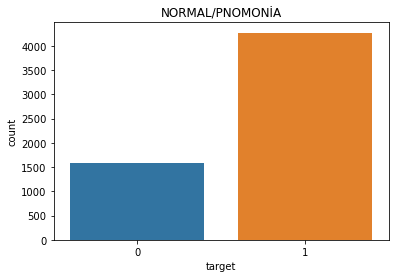

1    72.967896
0    27.032104
Name: target, dtype: float64


In [135]:
sns.countplot(full_data["target"])
plt.title("NORMAL/PNOMONİA")
plt.show()
print(full_data["target"].value_counts(normalize=True)*100)

**Observation** 
- Clearly, the data seems to be imbalanced in this case. Now in order to balance the distribution of the training examples, we would be using data augmentation procedure. first let's visualize the images to see the X-ray that is Normal and not Normal(Pneumonia).

## Data Preparation

There was inbalanced target categories, in order to work on our dataset and avoid highly biased results we had to augment the  dataset. We used Data Augmentation to increase the size of our data based on the existing data. These acts as a regularizer to help reduce overfitting, especially in this case where we have an imbalanced target. Also, our target appears in different dimension , and conditions. for example some are colors while some are grayscale, we had to use the augmentation techniques transform all the images into the same scales.

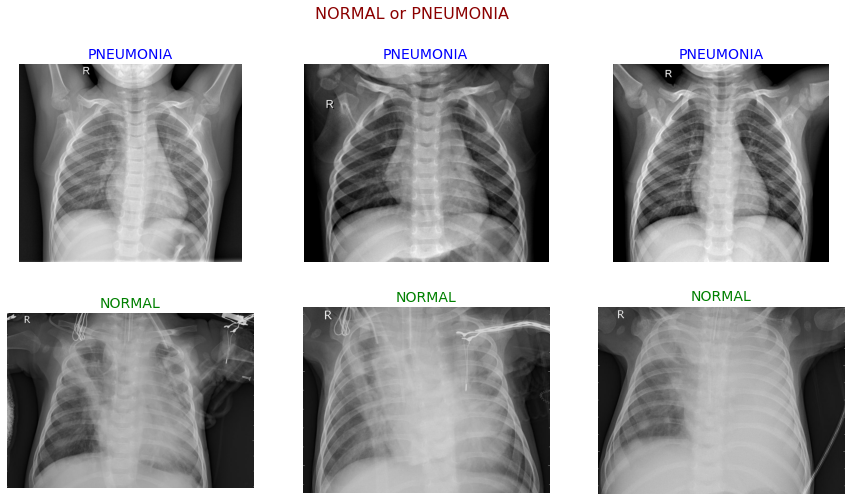

In [136]:
#plot the images that is normal and Pneumonia
plt.figure(figsize=(15,8))

plt.subplot(2,3,1) 
img = load_img(train_dir + "/" + full_data["images"][0])
plt.imshow(img)
plt.title("PNEUMONIA", color = "blue", size = 14)
plt.axis("off")


plt.subplot(2,3,2) 
img = load_img(train_dir + "/" + full_data["images"][1])
plt.imshow(img)
plt.title("PNEUMONIA", color = "blue", size = 14)
plt.axis("off")

plt.subplot(2,3,3) 
img = load_img(train_dir + "/" + full_data["images"][10])
plt.imshow(img)
plt.title("PNEUMONIA", color = "blue", size = 14)
plt.axis("off")

plt.subplot(2,3,4) 
img = load_img(train_dir + "/" + full_data["images"][3875])
plt.imshow(img)
plt.title("NORMAL", color = "green", size = 14)
plt.axis("off")

plt.subplot(2,3,5) 
img = load_img(train_dir + "/" + full_data["images"][3876])
plt.imshow(img)
plt.title("NORMAL", color = "green", size = 14)
plt.axis("off")

plt.subplot(2,3,6) 
img = load_img(train_dir + "/" + full_data["images"][3877])
plt.imshow(img)
plt.title("NORMAL", color = "green", size = 14)
plt.axis("off")

plt.suptitle("NORMAL or PNEUMONIA", size = 16, color = "darkred")
plt.show()

# Data Augmentation
- Data augmentation is used to increase the size of our data based on the existing data. it acts as a regularizer to help reduce overfitting, especially in this case where we have an imbalanced target.

In [137]:
# Fitting the CNN to the images
# The function ImageDataGenerator augments your image by iterating through image as your CNN is getting ready to process that image

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.3,
                                   brightness_range=(0.9,1),
                                   zoom_range = 0.3,
                                   validation_split= 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.

val_datagen = ImageDataGenerator(rescale = 1./255) #Image normalization.

training_generator = train_datagen.flow_from_directory(train_dir,
                                                       target_size = (64, 64),
                                                       batch_size = 32,
                                                       subset = 'training',
                                                       color_mode='grayscale',
                                                       class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(64, 64),
                                                  batch_size=32,
                                                  color_mode='grayscale',
                                                  class_mode='binary',
                                                  shuffle = False)

val_generator = train_datagen.flow_from_directory(train_dir,
                                                  target_size = (64, 64),
                                                  batch_size = 32,
                                                  class_mode = 'binary',
                                                  color_mode='grayscale',
                                                  subset ='validation')

Found 4695 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 521 images belonging to 2 classes.


- We holdout 10% of our training dataset as our validation data so we can use it during the learning process.

In [138]:
#define an input shape for modeling
input_shape = X_train.shape[1:]
input_shape

(64, 64, 1)

## Modeling

- We created a baseline model with Neural Network and predict it on our unseen dataset(test set), while trying to maximize accuracy and precision, at the same time minimize the loss function.

- We did feature engineering with Conv2d modeling using the Maxpooling techniques, and added more layers. The model seems to perform better than the baseline. 

- Used VGG19 pretrained CNN model. after several iteration and tunning we are able to achieve an accuracy score of 90% with a minimal loss function which is our aim for the modeling. 

### Baseline Understanding

- Here we build a baseline model to see how our model will predict on the majority of the class, so we can compare the score with other models.

In [50]:
model = keras.Sequential(
    [
        keras.Input(shape= (input_shape)), 
        layers.Flatten(), 
        layers.Dense(10, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
         ])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                40970     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 40,981
Trainable params: 40,981
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [52]:
baseline = model.fit_generator(training_generator, 
                    steps_per_epoch = 10,                     
                    epochs=5 , 
                    validation_data = val_generator,
                    validation_steps = 1)

Epoch 1/5
10/10 [==============================] - 4s 357ms/step - loss: 0.6260 - accuracy: 0.7031 - val_loss: 0.5770 - val_accuracy: 0.7812
Epoch 2/5
10/10 [==============================] - 3s 308ms/step - loss: 0.5597 - accuracy: 0.7437 - val_loss: 0.3674 - val_accuracy: 0.8750
Epoch 3/5
10/10 [==============================] - 3s 320ms/step - loss: 0.5393 - accuracy: 0.7344 - val_loss: 0.5546 - val_accuracy: 0.7188
Epoch 4/5
10/10 [==============================] - 3s 309ms/step - loss: 0.5102 - accuracy: 0.7531 - val_loss: 0.4675 - val_accuracy: 0.7812
Epoch 5/5
10/10 [==============================] - 3s 308ms/step - loss: 0.5264 - accuracy: 0.7031 - val_loss: 0.4766 - val_accuracy: 0.7812


In [53]:
evaluate_model(model)

Instructions for updating:
Please use Model.evaluate, which supports generators.
Acuracy of the model is:  74.28023219108582 %
Loss of the model is:  0.4903593361377716


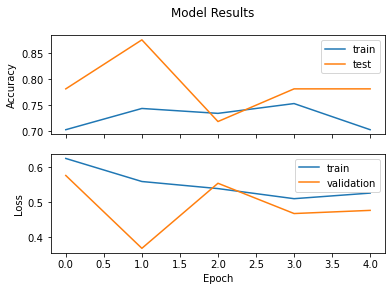

In [54]:
visualize_training_results(baseline)

- Our baseline model is overfitting on the majority class also, the loss function is very high. That said, we are going to be looking into another model to compare the scores. 

### First Substandard Model

Here we are going to use batchnormalization and padding to extend the area of which the convolutional neural network processes the image in our model.

In [55]:
#instantiate Sequential and input the shape.
model1 = Sequential()
model1.add(Conv2D(32,(3,3),activation = 'relu',padding='same',input_shape = input_shape))
model1.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D())


#Layers
model1.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model1.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D())


#layers
model1.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model1.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D())


#output
model1.add(Flatten())
model1.add(Dense(1200, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy',
             optimizer ='adam',
             metrics=['accuracy'])

model1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)       

In [24]:
#we are creating a early stopping so that when our 
#model reaches the desired level we can stop it
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [58]:
results = model1.fit_generator(training_generator,
                             steps_per_epoch= 4695//32,
                             epochs =10,
                             validation_data = val_generator,
                             validation_steps= 521//32,
                             callbacks=[early_stopping])

Epoch 1/10
146/146 [==============================] - 60s 412ms/step - loss: 0.1489 - accuracy: 0.9485 - val_loss: 1.2223 - val_accuracy: 0.7637
Epoch 2/10
146/146 [==============================] - 60s 413ms/step - loss: 0.1510 - accuracy: 0.9468 - val_loss: 6.5360 - val_accuracy: 0.7422
Epoch 3/10
146/146 [==============================] - 62s 424ms/step - loss: 0.1461 - accuracy: 0.9449 - val_loss: 0.3483 - val_accuracy: 0.8457
Epoch 4/10
146/146 [==============================] - 61s 418ms/step - loss: 0.1303 - accuracy: 0.9492 - val_loss: 0.5804 - val_accuracy: 0.8457
Epoch 5/10
146/146 [==============================] - 61s 415ms/step - loss: 0.1321 - accuracy: 0.9500 - val_loss: 0.4381 - val_accuracy: 0.8047
Epoch 00005: early stopping


In [59]:
#evaluate the model
evaluate_model(model1)

Acuracy of the model is:  80.42226433753967 %
Loss of the model is:  0.41659462451934814


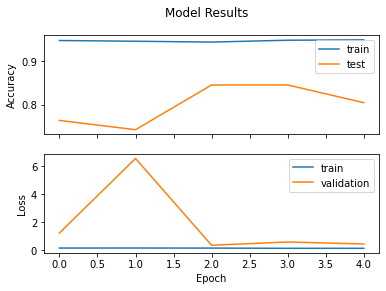

In [60]:
#visualize the model
visualize_training_results(results)

- The model did not converge eventhough we increase the size and normalize the dataset.Meaning that BatchNormalization techniques is not what we really need for these datasets.We are going to iterate and tune the model for a better accuracy score and minimum loss function.

### Modeling Iterations

We decided to use padding techniques, 2x2 Maxpooling2D and a 2x2 strides parameters to tune our model and predict it on our hold-out set.

In [63]:
#instantiate Sequential and input the shape.
model3 = Sequential()
model3.add(Conv2D(32,(3,3),activation = 'relu',padding='same',input_shape = input_shape))
model3.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model3.add(MaxPooling2D((2,2),strides=(2,2)))

#Layers
model3.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model3.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model3.add(MaxPooling2D((2,2),strides=(2,2)))

#layers
model3.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model3.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model3.add(MaxPooling2D((2,2), strides = (2,2)))

#output
model3.add(Flatten())
model3.add(Dense(900, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy',
             optimizer ='adam',
             metrics=['accuracy'])

model3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 64)       

In [64]:
#fit on the model
results3= model3.fit_generator(training_generator,
                             steps_per_epoch=4695//32,
                             epochs = 15,
                             validation_data = val_generator,
                             validation_steps= 521//32)

Epoch 1/15
146/146 [==============================] - 63s 428ms/step - loss: 0.5167 - accuracy: 0.7639 - val_loss: 0.4056 - val_accuracy: 0.7715
Epoch 2/15
146/146 [==============================] - 59s 404ms/step - loss: 0.3021 - accuracy: 0.8670 - val_loss: 0.3178 - val_accuracy: 0.8496
Epoch 3/15
146/146 [==============================] - 58s 400ms/step - loss: 0.2328 - accuracy: 0.9022 - val_loss: 0.2795 - val_accuracy: 0.8574
Epoch 4/15
146/146 [==============================] - 58s 396ms/step - loss: 0.2114 - accuracy: 0.9119 - val_loss: 0.2378 - val_accuracy: 0.8965
Epoch 5/15
146/146 [==============================] - 61s 415ms/step - loss: 0.1816 - accuracy: 0.9290 - val_loss: 0.2043 - val_accuracy: 0.9102
Epoch 6/15
146/146 [==============================] - 59s 401ms/step - loss: 0.1787 - accuracy: 0.9307 - val_loss: 0.2139 - val_accuracy: 0.9023
Epoch 7/15
146/146 [==============================] - 60s 412ms/step - loss: 0.1638 - accuracy: 0.9389 - val_loss: 0.2115 - val_ac

In [65]:
#evaluate the model
evaluate_model(model3)

Acuracy of the model is:  91.17082357406616 %
Loss of the model is:  0.21151135861873627


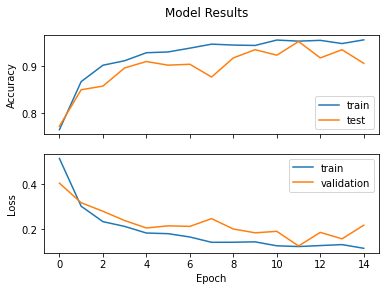

In [66]:
#visualize how it is performing on test data
visualize_training_results(results3)

Our model seems to be performing better than the first substandard model, but we are not able to minimize loss function even though we have a high accuracy score. we are going to move forward and tune the model again for a final accuracy score that will perform better on the holdout dataset.

### Pretrained Models

From here we decided to try out the pretrained model 'VGG19' to enhance the performance of the model. First, we will inititate the VGG19, with weights ='imagenet', include_top = False. Since the pretrained model cannot process the grayscale image, we will redefine each generators. Then, we will define new input shape as (64,64,3), since the pretrained model requires 3 channels.

In [26]:
training_generator = train_datagen.flow_from_directory(train_dir,
                                                       target_size = (64, 64),
                                                       batch_size = 32,
                                                       subset = 'training',
                                                       class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(64, 64),
                                                  batch_size=32,
                                                  class_mode='binary',
                                                  shuffle = False)

val_generator = train_datagen.flow_from_directory(train_dir,
                                                  target_size = (64, 64),
                                                  batch_size = 32,
                                                  class_mode = 'binary',
                                                  subset ='validation')

Found 4695 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 521 images belonging to 2 classes.


In [27]:
# Initiate Pretrained model VGG19
pretrained = VGG19(weights='imagenet',
                   include_top=False,
                   input_shape=(64,64,3))

# check the summary of VGG19
pretrained.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

#### Pretrained Model 1.0

In [32]:
# Initiate the Sequential model
# add a VGG19 layers
model4 = Sequential()
model4.add(pretrained)

# set VGG19 layers to not learn during fitting
for layer in model4.layers:
    layer.trainable=False 

In [33]:
# Flatten the VGG19 layers
model4.add(Flatten())

# Add 1 layer of 128 units and relu activation
# Add drop out with rate or 0.4
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.4))

# Add output layer with 1 unit and sigomoid activation
model4.add(Dense(1, activation = 'sigmoid'))

# Check the summary of the model
model4.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 20,286,785
Trainable params: 262,401
Non-trainable params: 20,024,384
_________________________________________________________________


In [34]:
# check the trainability of each layer
for layer in model4.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten_2 True
dense_4 True
dropout_2 True
dense_5 True


In [35]:
# Compile the model
model4.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [36]:
# fit the model
results4 = model4.fit_generator(training_generator,
                             steps_per_epoch=4695//32,
                             epochs =20,
                             validation_data = val_generator,
                             validation_steps= 521//32,
                             callbacks=[early_stopping])

Epoch 1/20
146/146 [==============================] - 95s 651ms/step - loss: 0.3521 - accuracy: 0.8417 - val_loss: 0.2808 - val_accuracy: 0.8613
Epoch 2/20
146/146 [==============================] - 91s 624ms/step - loss: 0.2478 - accuracy: 0.8936 - val_loss: 0.2587 - val_accuracy: 0.8672
Epoch 3/20
146/146 [==============================] - 96s 660ms/step - loss: 0.2414 - accuracy: 0.8992 - val_loss: 0.2235 - val_accuracy: 0.9082
Epoch 4/20
146/146 [==============================] - 99s 679ms/step - loss: 0.2153 - accuracy: 0.9123 - val_loss: 0.2219 - val_accuracy: 0.8926
Epoch 5/20
146/146 [==============================] - 90s 614ms/step - loss: 0.2242 - accuracy: 0.9026 - val_loss: 0.2143 - val_accuracy: 0.9121
Epoch 6/20
146/146 [==============================] - 95s 648ms/step - loss: 0.2086 - accuracy: 0.9125 - val_loss: 0.2546 - val_accuracy: 0.8809
Epoch 7/20
146/146 [==============================] - 91s 623ms/step - loss: 0.1868 - accuracy: 0.9284 - val_loss: 0.2513 - val_ac

In [37]:
#evaluate the model
evaluate_model(model4)

Instructions for updating:
Please use Model.evaluate, which supports generators.
Acuracy of the model is:  90.21113514900208 %
Loss of the model is:  0.21874994039535522


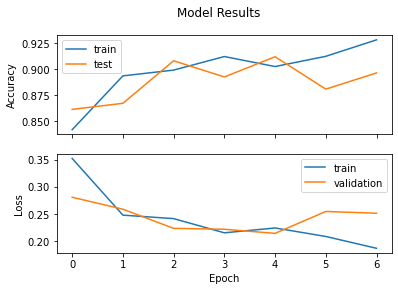

In [39]:
#visualize how it is performing on test data
visualize_training_results(results4)

Our initial pretrained model performs similar to the previously tuned model (accuracy = 91.17% and loss of .2115). We can see there is a potential of creating the final model using a pretrained model. We will move on to further tuning of pretrained model to minimize the loss.

#### Pretrained model 2.0

We will try to change the learning rate and fit the model to see if it shows the better performance.

In [88]:
# Initiate the Sequential model
# add a VGG19 layers
model5 = Sequential()
model5.add(pretrained)

# set VGG19 layers to not learn during fitting
for layer in model5.layers:
    layer.trainable=False 

In [89]:
# Flatten layer
model5.add(Flatten())

# Output Layer
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.4))
model5.add(Dense(1, activation = 'sigmoid'))

# Summary
model5.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 129       
Total params: 20,286,785
Trainable params: 262,401
Non-trainable params: 20,024,384
_________________________________________________________________


In [90]:
# check if pretrained model's trainability is False
for layer in model5.layers:
    print(layer.name, layer.trainable)

vgg19 False
flatten_9 True
dense_26 True
dropout_17 True
dense_27 True


In [91]:
# Compile the model
model5.compile(loss='binary_crossentropy',
            optimizer=Adam(1e-4),
            metrics=['accuracy'])

Since the slower learning rate requires more epochs to learn, we will not use early stop for this model fitting.

In [92]:
# Fit the model
results5 = model5.fit_generator(training_generator,
                             steps_per_epoch=4695//32,
                             epochs =20,
                             validation_data = val_generator,
                             validation_steps= 521//32)

Epoch 1/20
146/146 [==============================] - 94s 645ms/step - loss: 0.4504 - accuracy: 0.7877 - val_loss: 0.3656 - val_accuracy: 0.8320
Epoch 2/20
146/146 [==============================] - 85s 583ms/step - loss: 0.3363 - accuracy: 0.8563 - val_loss: 0.3110 - val_accuracy: 0.8516
Epoch 3/20
146/146 [==============================] - 96s 654ms/step - loss: 0.2950 - accuracy: 0.8754 - val_loss: 0.3021 - val_accuracy: 0.8516
Epoch 4/20
146/146 [==============================] - 89s 610ms/step - loss: 0.2706 - accuracy: 0.8833 - val_loss: 0.2831 - val_accuracy: 0.8809
Epoch 5/20
146/146 [==============================] - 102s 697ms/step - loss: 0.2595 - accuracy: 0.8947 - val_loss: 0.2397 - val_accuracy: 0.9102
Epoch 6/20
146/146 [==============================] - 97s 665ms/step - loss: 0.2395 - accuracy: 0.9026 - val_loss: 0.2406 - val_accuracy: 0.8965
Epoch 7/20
146/146 [==============================] - 83s 569ms/step - loss: 0.2280 - accuracy: 0.9061 - val_loss: 0.2522 - val_a

In [93]:
#evaluate the model
evaluate_model(model5)

Acuracy of the model is:  90.78694581985474 %
Loss of the model is:  0.18767450749874115


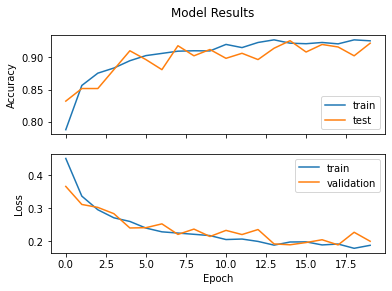

In [94]:
#visualize how it is performing on test data
visualize_training_results(results5)

We realized our pretrained model with lower learning rate shows good accuracy of 90% with the lowest loss up till now. Our loss plot also shows the difference between train loss and validation loss is significantly reduced. However, we will conduct the final tuning of the model and then decide the final model.

#### Pretrained Model 3.0

Our last try will be fine tuning the pretrained model. This process unfreezes part of the pretrained setand let that unfrozen layer to go under training. Applying fine-tuning allows us to utilize pre-trained networks to recognize classes they were not originally trained on.

In [95]:
# Check the layers inside the pretrained model
for i in range (len(pretrained.layers)):
    print (i,pretrained.layers[i])

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000015E97F75490>
1 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000015E97F755B0>
2 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000015E9481D850>
3 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000015E97F75CA0>
4 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000015E9833B2E0>
5 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000015E980230D0>
6 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000015E980234F0>
7 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000015E98028FD0>
8 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000015E9802B130>
9 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000015E980F8910>
10 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000015E980FDE20>
11 <tensorflow.python.keras.layers.pooling.MaxPooling2D object

We can see the pretrained model has a last block from line 17. Therefore, we will unfreeze the line 17 and below, while above 17 will be frozen.

In [96]:
# Freeze trainability of the layer above 17
# Unfreeze below 17
for layer in pretrained.layers[17:]:
    layer.trainable=True
for layer in pretrained.layers[0:17]:
    layer.trainable=False

In [98]:
# Double check trainability of the pretrained layer
for layer in pretrained.layers:
    print(layer.name, layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True


In [97]:
# Initiate the Sequential model
# add a VGG19 layers
model6 = Sequential()
model6.add(pretrained)

In [99]:
# Flatten layer
model6.add(Flatten())

# Output Layer
model6.add(Dense(128, activation='relu'))
model6.add(Dropout(0.4))
model6.add(Dense(1, activation = 'sigmoid'))

# Summary
model6.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_10 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 129       
Total params: 20,286,785
Trainable params: 262,401
Non-trainable params: 20,024,384
_________________________________________________________________


In [100]:
# Compile the model
model6.compile(loss='binary_crossentropy',
            optimizer=Adam(1e-4),
            metrics=['accuracy'])

In [101]:
# Fit the model
results6 = model6.fit_generator(training_generator,
                             steps_per_epoch=4695//32,
                             epochs =20,
                             validation_data = val_generator,
                             validation_steps= 521//32)

Epoch 1/20
146/146 [==============================] - 90s 616ms/step - loss: 0.4811 - accuracy: 0.7787 - val_loss: 0.3804 - val_accuracy: 0.8223
Epoch 2/20
146/146 [==============================] - 89s 610ms/step - loss: 0.3577 - accuracy: 0.8409 - val_loss: 0.3279 - val_accuracy: 0.8457
Epoch 3/20
146/146 [==============================] - 93s 636ms/step - loss: 0.3055 - accuracy: 0.8658 - val_loss: 0.2966 - val_accuracy: 0.8535
Epoch 4/20
146/146 [==============================] - 93s 635ms/step - loss: 0.2754 - accuracy: 0.8885 - val_loss: 0.2767 - val_accuracy: 0.8730
Epoch 5/20
146/146 [==============================] - 92s 631ms/step - loss: 0.2593 - accuracy: 0.8904 - val_loss: 0.2571 - val_accuracy: 0.9043
Epoch 6/20
146/146 [==============================] - 90s 614ms/step - loss: 0.2443 - accuracy: 0.8981 - val_loss: 0.2644 - val_accuracy: 0.8789
Epoch 7/20
146/146 [==============================] - 90s 615ms/step - loss: 0.2393 - accuracy: 0.9005 - val_loss: 0.2605 - val_ac

In [102]:
#evaluate the model
evaluate_model(model6)

Acuracy of the model is:  91.93857908248901 %
Loss of the model is:  0.20637039840221405


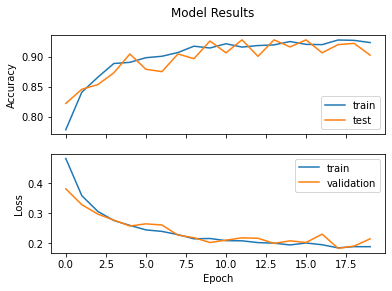

In [103]:
#visualize how it is performing on test data
visualize_training_results(results6)

Pretrained Model 3.0 also shows similar performance both in plot and scores. However, the loss of 2.0 is lower than the current model. Therefore, we will select pretrained model 2.0 to be our final model. 

## Evaluation

Based on the iterations, we have decided that our final model is pretrained model 2.0. Since we have decided our final model, we will start an evaluation of our model on the hold out test set.

In [105]:
# Evaluate model on test set
print('Acuracy of the model is: ',model5.evaluate_generator(test_generator)[1]*100, "%")
print('Loss of the model is: ', model5.evaluate_generator(test_generator)[0])

Acuracy of the model is:  89.26281929016113 %
Loss of the model is:  0.26147958636283875


In [114]:
# set y_true 
y_true = np.expand_dims(test_generator.classes, axis =1)

# create a y_pred 
y_pred = model5.predict(test_generator)

# Round the prediction of model to 0 and 1
y_pred = np.array([np.round(x) for x in y_pred])

# Create Confusion matrix
cmat = confusion_matrix(y_true, y_pred, normalize='true')
cmd = ConfusionMatrixDisplay(cmat, display_labels=test_generator.class_indices)

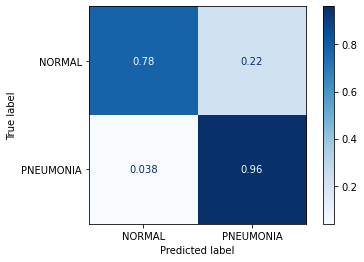

In [117]:
cmd.plot(cmap='Blues')

- Our model predicts correctly for 89% of the time with low loss. This means our model is more generalizable and can be applied to real world pneumonia detection. 
- Confusion Matrix shows that our model successfully detect the 96% of the pneumonia patient to be positive. This means our model has a high recall and our model succesfully reduce the chance of patients to not get instant treatment. This will lead to reducing mortality rate.

## Conclusions

- We recommend the Doctors and Radiology Society to employ our predictive model to identify which patients have Pneumonia and the risk. Our model will also help the Radiology Society reduce grading errors when looking at the X-Ray images, using our model to predict can help them identify the high risk patients with that they can quickly start medication.

- To use the model effectively, Doctors and Radiology Society need to gather enough Chest X-ray images, look at the dimension,and use it to predict the categories, that will maximize the potential of the model for accuracy while minimizing the loss.

- Our model successfully increased a accuracy while showing high recall. However, we have relatively low precision score which can be further tuned in the next steps.


## Next Steps
- **Further Tuning:** It is an eternal goal for the diagnostic exams to reduce the cases of both false-positive and false-negative. Our model shows high recall but relatively low precision. Therefore, we can further tune the model to reduce precision while maintaining current recall score.
- **Larger Dataset:** The dataset size is considered a critical property in determining the performance of a model. As the dataset grows larger, our observation gets more dense, and the more confident we can be about our model's predictions. Therefore, gathering more chest X-ray image will help enhance the performance of the model.
- **Application to Covid-19:** Pneumonia is one of the common symptoms of Covid-19. There are reported pneumonia cases where the viral infection could not be detected on the X-ray image, then suddenly the condition of the patient gets worse, ended up in the fatal conditions. By training our model with the chest X-ray images of the Covid -19 patients, there is a chance to apply this model to detecting pneumonia from Covid-19 patients before condition becomes fataly unwell and reduce the mortality rate.